# IMPORT SECTION

In [ ]:
!pip install --upgrade music21
from music21 import converter, instrument, note, chord
import os
from tqdm import tqdm
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout
%load_ext tensorboard 
from tensorboard import notebook
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

     |████████████████████████████████| 19.3MB 1.2MB/s 
  Created wheel for music21: filename=music21-6.7.1-cp37-none-any.whl size=21941694 sha256=108775d8e7b7cc09a78abfbc5558bd619035824294e2a270511d4aa3bfaa06f4
  Stored in directory: /root/.cache/pip/wheels/1a/0f/0e/f78ad56a2738f4ea5082dd4283d7b7cce18a8ba20c3e609b6c
Successfully built music21
  Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [ ]:

from google.colab import drive

drive.mount('/content/drive', force_remount=False)

MIDI_PATH="/content/drive/My Drive/MLFolder/Onlab/MIDI_Iron_Maiden/"

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Mar  7 11:54:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# UTILITY FUNCTIONS SECTION

In [ ]:
#https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/

def most_frequent(paramlist): 
    counter = 0
    num = paramlist[0] 
      
    for i in paramlist: 
        curr_frequency = paramlist.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num 

#Utility functions

def get_notes_from_chord(chord):
    if chord.startswith("<music21.chord.Chord "):
        chord = chord[len("<music21.chord.Chord "):]
    if chord.endswith(">"):
        chord = chord[:-1]
    chord = chord.replace(" ", ",")
    return chord

def get_number_from_duration(duration):
    if duration.startswith("<music21.duration.Duration "):
        duration = duration[len("<music21.duration.Duration "):]
    if duration.endswith(">"):
        duration = duration[:-1]
    duration = duration.replace(" ", ",")
    return duration

def create_mapper(chords):
    pitchnames = sorted(set(str(item) for item in chords))
    mapper = dict((note, number) for number, note in enumerate(pitchnames))

    return mapper

def encode_using_mapper(chords, mapper):
    encodedsong=[]
    for c in chords:
        encodedsong.append(mapper[str(c)])

    return encodedsong


def decode_chords_using_mapper(numbers, mapper):
    outputnotes = []
    for number in numbers:
        outputnotes.append(chord_from_string(get_notes_from_chord(get_key_from_value(number, mapper))))

    return outputnotes

def combine_chords_with_durations(chords, durations):
    combined = []

    for i, j in zip(chords, durations):
        i = get_notes_from_chord(str(i))
        j = get_number_from_duration(str(j))
        combined.append(i + ';' + j)

    return combined

def make_slices(data, slice_length):
    for song in tqdm(data):
        if len(song) > slice_length:

            input = []
            output = []
            slice = []

            for idx, number in enumerate(song):
                if idx < slice_length:
                    slice.append(number)

            input.append(slice.copy())
            output.append(song[slice_length])

            # Sliding window
            for idx, number in enumerate(song):
                if idx >= slice_length and (idx + 1) < len(song):
                    slice.pop(0)
                    slice.append(number)
                    input.append(slice.copy())  # Copy is necessary, because of how pointers and lists work in Python
                    output.append(song[idx + 1])

    return input, output

def parse_everything_together(data, slice_length):

    notes=[]
    input=[]
    output=[]
    slice = []

    for song in tqdm(data):
        for number in song:
            notes.append(number)
    
    for idx, note in tqdm(enumerate(notes)):
        if idx < slice_length:
            slice.append(number)

    input.append(slice.copy())
    output.append(notes[slice_length])

    # Sliding window
    for idx, number in tqdm(enumerate(notes)):
        if idx >= slice_length and (idx + 1) < len(notes):
            slice.pop(0)
            slice.append(number)
            input.append(slice.copy())  # Copy is necessary, because of how pointers and lists work in Python
            output.append(notes[idx + 1])
        
    return input, output

def get_key_from_value(value, dict):
    return list(dict.keys())[list(dict.values()).index(value)]

def get_notes_from_chord(chord):
    if chord.startswith("<music21.chord.Chord "):
        chord = chord[len("<music21.chord.Chord "):]
    if chord.endswith(">"):
        chord = chord[:-1]
    chord = chord.replace(" ", ",")
    return chord

def get_number_from_duration(duration):
    if duration.startswith("<music21.duration.Duration "):
        duration = duration[len("<music21.duration.Duration "):]
    if duration.endswith(">"):
        duration = duration[:-1]
    duration = duration.replace(" ", ",")
    return duration

def chord_from_string(chordstring):
    notes = chordstring.split(";")
    return chord.Chord(notes)

#From: https://stackoverflow.com/questions/1806278/convert-fraction-to-float
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

#Source: https://github.com/alexissa32/DataScienceMusic
def create_midi_without_chords(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    '''
    First step:
    Only notes, no chords
    Static 4/4 beat
    Rests
    '''
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a rest
        if('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_without_durations(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    '''
    Second step:
    Chords and notes
    Static 4/4 beat
    Rests
    '''
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('chord' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_with_durations(prediction_output, output_durations, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for i in range(len(prediction_output)):
        pattern = prediction_output[i]
        duration = get_number_from_duration(output_durations[i])
        # pattern is a chord
        if ('chord' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_with_embedded_durations(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for i in range(len(prediction_output)):
        pattern = prediction_output[i]
        splitpattern = pattern.split(";")
        pattern = splitpattern[0]

        duration = get_number_from_duration(splitpattern[1])
        # pattern is a rest
        if('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a chord
        elif (',' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

# PREPROCESSING SECTION

In [ ]:
class MidiPart:
    def __init__(self, song, instrument, chords, durations):
        self.song = song
        self.instrument = instrument
        self.chords = chords
        self.durations = durations


path = MIDI_PATH

IRON_MAIDEN_INSTRUMENTS = ['Acoustic Guitar', 'Viola', 'Electric Bass', 'Brass', 'Sampler', 'Electric Guitar', 'Piano', 'StringInstrument']

TARGET_INSTRUMENT = 'Electric Bass'

SLICE_LEN = 20




In [ ]:
midiparts = []

for file in tqdm(os.listdir(path)):
    midi = converter.parse(os.path.join(path, file))

    for part in midi.parts:
        chords=[]
        durations=[]
        for element in part.notesAndRests:
            if isinstance(element, note.Note):
                chords.append(chord.Chord([element]))
                durations.append(element.duration)
            elif isinstance(element, chord.Chord):
                chords.append(element)
                durations.append(element.duration)
            elif isinstance(element, note.Rest):
                chords.append(element)
                durations.append(element.duration)

        if len(chords) > 0:
            midiparts.append(MidiPart(file, part.partName, chords, durations))
        else:
            for voice in part.voices:
                chords=[]
                durations=[]
                for element in voice.notesAndRests:
                    if isinstance(element, note.Note):
                        chords.append(chord.Chord([element]))
                        durations.append(element.duration)
                    elif isinstance(element, chord.Chord):
                        chords.append(element)
                        durations.append(element.duration)
                    elif isinstance(element, note.Rest):
                        chords.append(element)
                        durations.append(element.duration)

                midiparts.append(MidiPart(file, part.partName, chords, durations))

100%|██████████| 93/93 [13:44<00:00,  8.87s/it]


In [ ]:
#Akkordok nélkül, restekkel
midiparts = []

for file in tqdm(os.listdir(path)):
    midi = converter.parse(os.path.join(path, file))

    for part in midi.parts:
        notes=[]
        durations=[]
        for element in part.notesAndRests:
            if isinstance(element, note.Note):
                notes.append(element.pitch)
                durations.append(element.duration)
            elif isinstance(element, chord.Chord):
                notes.append(element.root())
                durations.append(element.duration)
            elif isinstance(element, note.Rest):
                notes.append(element)
                durations.append(element.duration)

        if len(notes) > 0:
            midiparts.append(MidiPart(file, part.partName, notes, durations))
        else:
            for voice in part.voices:
                notes=[]
                durations=[]
                for element in voice.notesAndRests:
                    if isinstance(element, note.Note):
                        notes.append(element.pitch)
                        durations.append(element.duration)
                    elif isinstance(element, chord.Chord):
                        notes.append(element.root())
                        durations.append(element.duration)
                    elif isinstance(element, note.Rest):
                        notes.append(element)
                        durations.append(element.duration)

                midiparts.append(MidiPart(file, part.partName, notes, durations))

In [ ]:
#Restek nélkül, akkordok nélkül
midiparts = []

for file in tqdm(os.listdir(path), position=0, leave=True):
    midi = converter.parse(os.path.join(path, file))

    for part in midi.parts:
        for voice in part.voices:
            notes=[]
            durations=[]
            for element in voice.notes: 
                if isinstance(element, note.Note):
                    notes.append(element.pitch)
                    durations.append(element.duration)
                elif isinstance(element, chord.Chord):
                    notes.append(element.root())
                    durations.append(element.duration)
                elif isinstance(element, note.Rest):
                    notes.append(element)
                    durations.append(element.duration)

            midiparts.append(MidiPart(file, part.partName, notes, durations))

In [ ]:
allchords = []
alldurations = []

#TARGET_INSTRUMENT = 'Electric Guitar'
for i in midiparts:
    if i.instrument == TARGET_INSTRUMENT:
        if len(i.chords)>0 :
            allchords.append(i.chords)
            alldurations.append(i.durations)

In [ ]:
assert(len(allchords) == len(alldurations))

combined = []
for i in range(len(allchords)):
    combined.append(combine_chords_with_durations(allchords[i], alldurations[i]))

mapperdata = []

for i in combined:
    for j in i:
        mapperdata.append(j)

mapper = create_mapper(mapperdata)

In [ ]:
encoded_data = []

for c in combined:
    encoded = encode_using_mapper(c, mapper)
    encoded_data.append(encoded)

#cleared_encoded_data=encoded_data

In [ ]:
#I create the Note/Chord/Rest to Number mapper here.

mapperdata = []

for i in allchords:
    for j in i:
        mapperdata.append(j)

mapper = create_mapper(mapperdata)

In [ ]:
#I encode the data here using the mapper.

encoded_data = []

for c in allchords:
    encoded = encode_using_mapper(c, mapper)
    encoded_data.append(encoded)


In [ ]:
restkeysvalues = []
for j in mapper.keys():
    if ( 'rest' in j):
        restkeysvalues.append(mapper[j])

cleared_encoded_data=[]


for i in encoded_data:
    if most_frequent(i) not in restkeysvalues:
        cleared_encoded_data.append(i)
    else:
        pass

In [ ]:
#I filter out those chord sequences, which are majorly rests. I do this because I don't want the network to make a song, which contains nothing, but rests. Our dataset has about 100 guitar tracks, which contain rests for the majority of the track, and a guitar solo near the end.
#An upgrade for this could be that I don't just delete those tracks from the dataset, but only filter out the rests, and leave the guitar solo in.


restnumber = mapper['<music21.note.Rest rest>']

cleared_encoded_data=[]

for i in encoded_data:
    if most_frequent(i) != restnumber:
        cleared_encoded_data.append(i)
    else:
        pass



In [ ]:
#Creating the input data

input, output = parse_everything_together(cleared_encoded_data, SLICE_LEN)

100%|██████████| 102/102 [00:00<00:00, 8944.39it/s]
158198it [00:00, 3067398.79it/s]
158198it [00:00, 700676.15it/s]


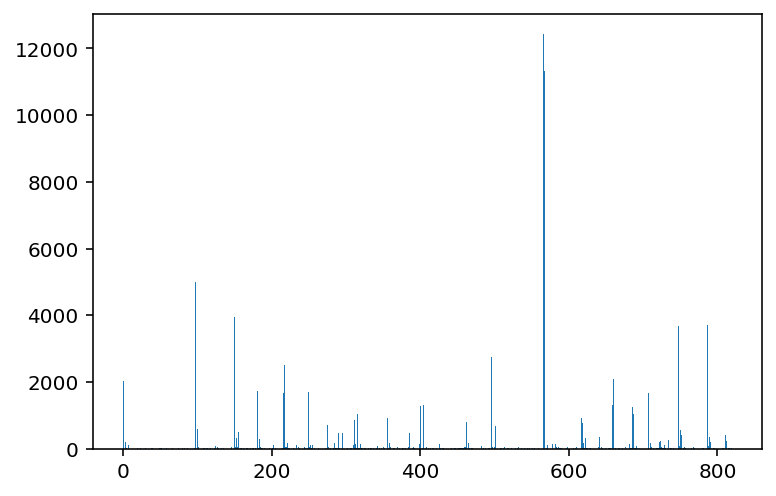

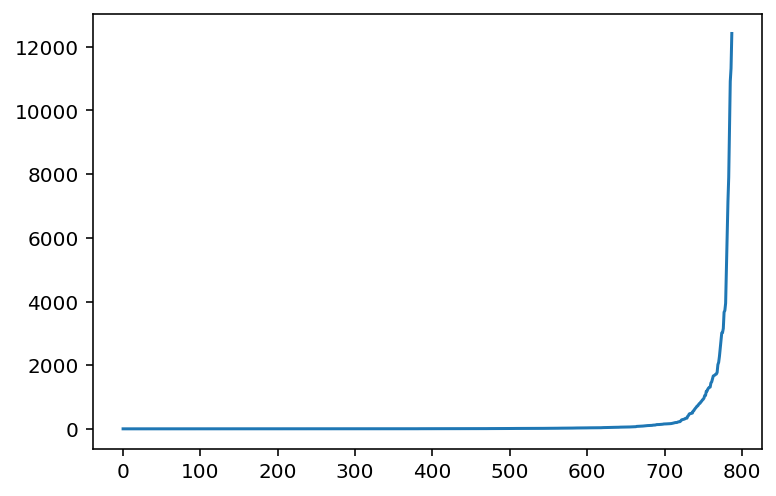

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

outputcnt = Counter(output)
plt.bar(outputcnt.keys(), outputcnt.values())
plt.show()

function_like_array=[]
for val in outputcnt.values():
    function_like_array.append(val)

function_like_array.sort()
plt.plot(function_like_array)

In [ ]:

outliers = []

for i in outputcnt.keys():
    if outputcnt[i] < 40:
        outliers.append(i)

print(outliers)
print(len(outliers))

[50, 281, 134, 590, 709, 717, 799, 142, 492, 301, 222, 647, 490, 214, 491, 299, 375, 502, 728, 607, 244, 283, 245, 597, 333, 457, 429, 611, 343, 430, 614, 53, 156, 23, 26, 254, 359, 737, 288, 74, 79, 205, 49, 64, 56, 688, 194, 195, 695, 478, 335, 697, 481, 171, 468, 175, 817, 508, 589, 35, 448, 192, 331, 408, 187, 318, 182, 414, 580, 763, 422, 66, 605, 600, 86, 368, 783, 58, 546, 305, 304, 94, 379, 215, 302, 376, 795, 552, 558, 556, 52, 291, 392, 338, 332, 230, 122, 764, 390, 383, 289, 292, 177, 172, 173, 683, 157, 625, 587, 170, 511, 621, 362, 585, 500, 557, 604, 229, 403, 317, 325, 115, 713, 190, 324, 106, 186, 705, 204, 357, 45, 452, 532, 673, 672, 447, 446, 235, 236, 451, 453, 454, 126, 531, 533, 534, 765, 767, 545, 18, 237, 128, 655, 280, 279, 278, 583, 507, 576, 256, 632, 158, 261, 732, 193, 141, 4, 117, 782, 704, 781, 105, 690, 13, 320, 703, 716, 419, 804, 592, 330, 96, 306, 547, 307, 550, 549, 548, 93, 303, 581, 39, 95, 377, 700, 381, 133, 699, 34, 572, 314, 436, 348, 145, 777,

In [ ]:
#Because I don't want to mess up my inputs and outputs, I test their lengths before and after the outlier filtering.
assert(len(input) == len(output))

newinput=[]
newoutput=[]

for i in range(len(output)):
    if(output[i] not in outliers):
        newinput.append(input[i])
        newoutput.append(output[i])

input = newinput
output = newoutput

assert(len(input) == len(output))

In [ ]:
#However, this outlier filtering made things complicated. Now I have to make a new mapper, so that i won't end up with output classes containing 0 elements.

mapper_list = [] #Idx of the mapper list is the new value, the element is the old value.
new_output_elements = set(output)

for i in new_output_elements:
    mapper_list.append(i)

newoutput = []

for i in output:
    newoutput.append(mapper_list.index(i))

output = newoutput

In [ ]:
#Reshaping the input data to be compatible with LSTMs and normalizing it in the hope of better learning.

input = np.reshape(np.asarray(input), (len(input), SLICE_LEN, 1))
output = to_categorical(output)

input=np.asarray(input) / float(len(mapper))
output=np.asarray(output)

In [ ]:
#TRAIN_VAL_TEST_SPLIT

SEED = 54
#np.random.seed(SEED)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(input, output, test_size=0.01, random_state=SEED)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=SEED)

startidx = np.random.randint(0, len(X_test)-1)
starting_slice = X_test[startidx]

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
print(startidx)
print(starting_slice)

(121952, 20, 1) (30489, 20, 1) (1540, 20, 1) (121952, 167) (30489, 167) (1540, 167)
198
[[0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.1195122 ]
 [0.60487805]
 [0.91219512]
 [0.1195122 ]]


# MODEL TRAINING SECTION

In [ ]:
MODEL_NAME = "bassmodelwithdurations20"

MODEL_SAVE_PATH = "/content/drive/MyDrive/MLFolder/Onlab/modelsaves"

TBPATH = "/content/tblogs/"+MODEL_NAME

In [ ]:
#Before creating the neural network, I define some important callbacks

tb = TensorBoard(log_dir = TBPATH, write_images=True, histogram_freq=1)

plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00005, verbose=1)

es = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True, verbose=1)

callbacks = [plateau, es, tb]



In [ ]:
#I create the neural network model here.

model = Sequential()
model.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(256))
model.add(Dense(Y_train.shape[1], activation='softmax'))


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=10000, batch_size=16, validation_data=(X_val, Y_val), callbacks=callbacks)

model.evaluate(X_test, Y_test)

model.save(MODEL_SAVE_PATH + MODEL_NAME + ".h5")

Epoch 1/10000
7622/7622 [==============================] - 91s 8ms/step - loss: 3.6088 - accuracy: 0.1453 - val_loss: 2.4298 - val_accuracy: 0.3638
Epoch 2/10000
7622/7622 [==============================] - 58s 8ms/step - loss: 2.2617 - accuracy: 0.3967 - val_loss: 1.9307 - val_accuracy: 0.4787
Epoch 3/10000
7622/7622 [==============================] - 58s 8ms/step - loss: 1.7533 - accuracy: 0.5184 - val_loss: 1.6686 - val_accuracy: 0.5480
Epoch 4/10000
7622/7622 [==============================] - 58s 8ms/step - loss: 1.4419 - accuracy: 0.6012 - val_loss: 1.4323 - val_accuracy: 0.6118
Epoch 5/10000
7622/7622 [==============================] - 58s 8ms/step - loss: 1.2140 - accuracy: 0.6599 - val_loss: 1.3159 - val_accuracy: 0.6459
Epoch 6/10000
7622/7622 [==============================] - 58s 8ms/step - loss: 1.0574 - accuracy: 0.6975 - val_loss: 1.2146 - val_accuracy: 0.6684
Epoch 7/10000
7622/7622 [==============================] - 58s 8ms/step - loss: 0.9418 - accuracy: 0.7278 - val_

In [ ]:
model.fit(X_train, Y_train, epochs=10000, batch_size=16, validation_data=(X_val, Y_val), callbacks=callbacks)

model.evaluate(X_test, Y_test)

model.save(MODEL_SAVE_PATH + MODEL_NAME + ".h5")

In [ ]:
model.evaluate(X_test, Y_test)

model.save(MODEL_SAVE_PATH + MODEL_NAME + ".h5")

68/68 [==============================] - 0s 4ms/step - loss: 1.3353 - accuracy: 0.7874


In [ ]:
#I use the TensorBoard here

%tensorboard --logdir="/content/tblogs/guitarmodelwithdurations16" #TODO FIX THIS TO BE A VARIABLE

# INFERENCE AND POSTPROCESSING SECTION

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    preds = np.squeeze(preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
def generate_notes(model, network_input, starting_slice, mapper, mapperlist = None, temp=1.0):
    """ Generate notes from the neural network based on a sequence of notes """
    pattern = starting_slice
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))

        prediction = model.predict(prediction_input, verbose=0)

        #prediction = sample(prediction, temp)
        index = sample(prediction, temp)

        #index = np.argmax(prediction)
        if mapperlist is not None: #Idx of the mapper list is the new value, the element is the old value. This is used when I filter for outliers.
            index=mapperlist[index]

        result = get_key_from_value(index, mapper)
        prediction_output.append(result)

        pattern = np.append(pattern, index/float(len(mapper)))

        pattern = pattern[1:len(pattern)]

    return prediction_output

In [ ]:
generated_outputs=[]

temperatures = [0.5, 0.7, 0.8, 0.9, 1.0, 1.2]

# DO NOT FORGET, IMPORTANT: When using outlier filtering, DO NOT FORGET to use the mapperlist parameter!!

for temp in tqdm(temperatures):
    generated_outputs.append(generate_notes(model, input, starting_slice, mapper, mapper_list, temp = temp))

 83%|████████▎ | 5/6 [01:18<00:15, 15.61s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
100%|██████████| 6/6 [01:33<00:00, 15.64s/it]


In [ ]:
for out in generated_outputs:
    print(out)

['B1;0.5', 'E1;0.5', 'A1;0.5', 'G1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.25', 'A1;0.25', 'A1;0.25', 'A1;0.25', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25', 'A1;0.5', 'A1;0.25', 'A1;0.25',

In [ ]:
from music21 import stream

STARTING_OFFSET = 6

OUTPUT_PATH = "/content/drive/MyDrive/MLFolder/Onlab/Outputs/"

for i, out in enumerate(generated_outputs):
    create_midi_with_embedded_durations(out, target_instrument = instrument.ElectricGuitar(), filename = OUTPUT_PATH + MODEL_NAME + f'{i+STARTING_OFFSET}.mid')

# DEBUG SECTION

In [ ]:
#This is a debug cell, with a lot of prints:

print(mapper)
print(len(mapper))

print(X_train[0])

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)


{'<music21.note.Rest,rest;0.25': 0, '<music21.note.Rest,rest;0.5': 1, '<music21.note.Rest,rest;0.75': 2, '<music21.note.Rest,rest;1.0': 3, '<music21.note.Rest,rest;1.25': 4, '<music21.note.Rest,rest;1.5': 5, '<music21.note.Rest,rest;1.75': 6, '<music21.note.Rest,rest;1/12': 7, '<music21.note.Rest,rest;1/3': 8, '<music21.note.Rest,rest;1/6': 9, '<music21.note.Rest,rest;10.0': 10, '<music21.note.Rest,rest;10.25': 11, '<music21.note.Rest,rest;10.5': 12, '<music21.note.Rest,rest;10.75': 13, '<music21.note.Rest,rest;10/3': 14, '<music21.note.Rest,rest;100.25': 15, '<music21.note.Rest,rest;100/3': 16, '<music21.note.Rest,rest;1001/3': 17, '<music21.note.Rest,rest;101/12': 18, '<music21.note.Rest,rest;101/6': 19, '<music21.note.Rest,rest;1033/12': 20, '<music21.note.Rest,rest;104.0': 21, '<music21.note.Rest,rest;104.5': 22, '<music21.note.Rest,rest;1040/3': 23, '<music21.note.Rest,rest;105.75': 24, '<music21.note.Rest,rest;106.0': 25, '<music21.note.Rest,rest;1065.0': 26, '<music21.note.Rest,

In [ ]:
debugarray = []
for i in midiparts:
    debugarray.append(i.instrument)

print(set(debugarray))

{'Electric Organ', 'Xylophone', 'Celesta', 'Viola', 'Electric Bass', 'Sampler', 'Brass', 'Acoustic Guitar', 'Voice', 'Electric Guitar', 'Acoustic Bass', 'Vibraphone', 'Accordion', 'Piano', 'StringInstrument', 'Violoncello'}
